Tisya Sharma 002903942

Professor Miguel Fuentes-Cabrera

14 November, 2025

DS4400: Machine Learning and Data Mining

Midterm Take Home Coding 2

I declare that the following work is entirely my own, and that I did not copy or seek help from any students who
have currently or previously taken this course, nor from any online source (incl. AI) other than private messages
between myself and the professor on Piazza/via email.

-- Tisya Sharma


### PROBLEM 1: REGULARIZATION (24 points)

In [1]:
import autograd.numpy as np
from autograd import grad  
from autograd.numpy import log, exp 
from scipy.integrate import quad

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


Part (a)

In [2]:
# Read the dataset
spotify = pd.read_csv("ds4400_spotify.csv")
display(spotify.head())

# Store song/artist names separately for later reference, then drop song name and artist names from spotify df
song_info = spotify[['song_title', 'artist_name']] if {'song_title','artist_name'}.issubset(spotify.columns) else None
spotify = spotify.drop(columns=["song_title", "artist_name"], errors="ignore")

# Separate target and features
y = spotify['danceability']
X = spotify.drop(columns=['danceability'])

# One-hot encode categorical features
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
dummy_mask = X.apply(lambda s: set(s.dropna().unique()) <= {0, 1})
dummy_cols = X.columns[dummy_mask]
X[dummy_cols] = X[dummy_cols].astype("int8")

# Normalize numeric features with min max scaler
# Scale only continuous numeric columns (leave dummies as 0 and 1)
cont_cols = X.columns.difference(dummy_cols)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X.copy()
X_scaled[cont_cols] = scaler.fit_transform(X_scaled[cont_cols])

# Build final feature map Phi with intercept
Phi = X_scaled.copy()
Phi.insert(0, 'intercept', 1.0)

# Show the feature map
display(Phi.head())
display(y.head())

,song_title,artist_name,danceability,energy,loudness,acousticness,tempo,mode
0,Hawk Em,Pop Smoke,0.680,0.607,-5.523,0.2640,141.992,Major
1,Faith,The Weeknd,0.370,0.603,-7.268,0.6120,175.962,Minor
2,Greek Tragedy - Oliver Nelson TikTok Remix,The Wombats,0.736,0.764,-6.736,0.2220,112.033,Minor
3,Homesick,Noah Kahan,0.505,0.624,-6.526,0.0253,170.076,Major
4,August,flipturn,0.450,0.602,-4.301,0.0892,172.161,Major


,intercept,energy,loudness,acousticness,tempo,mode_Minor
0,1.0,0.571661,0.758362,0.323175,0.563378,0
1,1.0,0.565147,0.590638,0.758545,0.836785,1
2,1.0,0.827362,0.641772,0.270630,0.322253,1
3,1.0,0.599349,0.661957,0.024546,0.789411,0
4,1.0,0.563518,0.875817,0.104489,0.806193,0


0    0.680
1    0.370
2    0.736
3    0.505
4    0.450
Name: danceability, dtype: float64

Part (b)

In [3]:
import matplotlib.pyplot as plt

# Put Phi and y into numpy form
Phi_np = Phi.values.astype(float)
y_np = y.values.reshape(-1, 1).astype(float)

# Mean squared error
def mse(w, Phi, y):
    n = Phi.shape[0]
    p = np.dot(Phi, w) - y
    return (1/n) * np.dot(p.T, p).item()

# Gradient of Lasso loss: MSE + λ * ||w||_1
def dfd(w, Phi, y, lam):
    n = Phi.shape[0]
    p = np.dot(Phi, w) - y
    grad_mse = (2/n) * np.dot(Phi.T, p)
    grad_l1  = lam * np.sign(w)
    return grad_mse + grad_l1

# Run gradient descent for Lasso
def run_lasso(Phi, y, lam, eta=0.01, steps=2000):
    d = Phi.shape[1]
    w = np.zeros((d, 1))
    error_list = []

    for t in range(steps):
        w = w - eta * dfd(w, Phi, y, lam)
        err = mse(w, Phi, y)
        error_list.append(err)

    return w, error_list


Part (c)

λ = 0.01: final MSE = 0.0202, R2 = 0.3747
λ = 0.1: final MSE = 0.0348, R2 = -0.0784


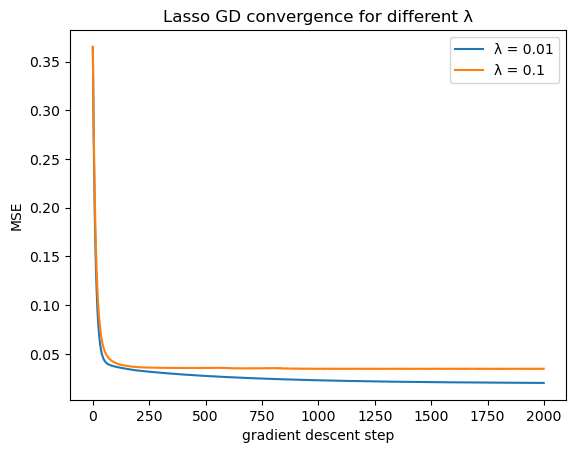

In [4]:
eta = 0.01
steps = 2000
lam_values = [0.01, 0.1]

results = {}      # λ -> (w, error_list)
final_mse = {}    # λ -> final MSE
r2_scores = {}    # λ -> R2

for lam in lam_values:
    # Gradient descent for this λ
    w_lam, err_list = run_lasso(Phi_np, y_np, lam, eta=eta, steps=steps)
    results[lam] = (w_lam, err_list)

    # R2 on the training data
    y_hat = np.dot(Phi_np, w_lam)
    ss_res = np.sum((y_np - y_hat)**2)
    ss_tot = np.sum((y_np - y_np.mean())**2)
    r2 = 1 - ss_res/ss_tot

    final_mse[lam] = err_list[-1]
    r2_scores[lam] = r2

    print(f'λ = {lam}: final MSE = {final_mse[lam]:.4f}, R2 = {r2:.4f}')

# Plot the error over iterations for both λ values
plt.plot(results[0.01][1], label='λ = 0.01')
plt.plot(results[0.1][1], label='λ = 0.1')
plt.xlabel('gradient descent step')
plt.ylabel('MSE')
plt.title('Lasso GD convergence for different λ')
plt.legend()
plt.show()


Part (d)

In [5]:
# Pick the λ with the smaller training error
best_lam = min(lam_values, key=lambda lam: final_mse[lam])
print(f'\nBest λ based on training MSE: {best_lam} (MSE = {final_mse[best_lam]:.4f})')

w_best, err_best = results[best_lam]

print('\nFinal weight vector (including intercept):')
for name, weight in zip(Phi.columns, w_best.ravel()):
    print(f'{name:30s} {weight: .4f}')

# Put coefficients in a DataFrame and sort by size
coef_df = pd.DataFrame({
    'feature': Phi.columns,
    'weight': w_best.ravel()
})
coef_df['abs_weight'] = coef_df['weight'].abs()

coef_df = coef_df.sort_values('abs_weight', ascending=False)
display(coef_df.head(15))



Best λ based on training MSE: 0.01 (MSE = 0.0202)

Final weight vector (including intercept):
intercept                       0.6011
energy                          0.0001
loudness                        0.0895
acousticness                   -0.0000
tempo                          -0.2254
mode_Minor                      0.0965


,feature,weight,abs_weight
0,intercept,0.601064,0.601064
4,tempo,-0.225401,0.225401
5,mode_Minor,0.096479,0.096479
2,loudness,0.089515,0.089515
1,energy,0.000065,0.000065
3,acousticness,-0.000027,0.000027


Between λ = 0.01 and λ = 0.1, λ = 0.01 gives the lower training MSE (≈ 0.020) and a higher R2 (≈ 0.37), so I treat λ = 0.01 as the better Lasso model. With this λ, tempo has the largest coefficient in magnitude (about −0.23), so tempo is the most influential predictor, and higher tempo is associated with slightly lower predicted danceability. Mode_Minor and loudness have moderate positive weights, so they also matter for predicting danceability, while energy and acousticness have coefficients very close to 0, meaning the L1 penalty has effectively removed them from the model and they are not very important once the other features are included.

### PROBLEM 2: SAMPLING (14 points)

theta = 1.0
Estimated E[X] from rejection sampling: 1.2526
True E[X] = theta * sqrt(pi/2): 1.2533
Absolute error: 0.0007


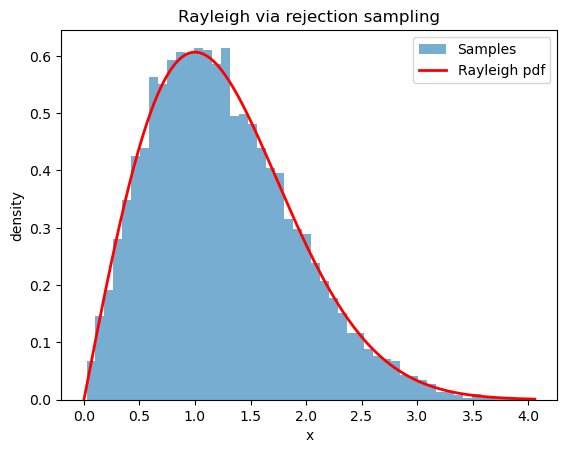

In [6]:
theta = 1.0   

# Rayleigh pdf
def rayleigh_pdf(x, theta=theta):
    if x < 0:
        return 0
    return (x/theta**2)*np.exp(-x**2/(2*theta**2))

# Proposal pdf: Exp(1)
def exp_pdf(x):
    if x < 0:
        return 0
    return np.exp(-x)

# Rejection sampling for the Rayleigh
# M chosen so that p(x) <= M * q(x)
# for θ = 1, max p/q ≈ 2.2
def rayleigh_rejection(num_samples=10000, M=2.3):
    samples = []
    while len(samples) < num_samples:
        x = np.random.exponential(1.0)
        u = np.random.uniform(0, 1)
        if u < rayleigh_pdf(x)/(M * exp_pdf(x)):
            samples.append(x)
    return np.array(samples)

# Draw samples and estimate E[X]
samples = rayleigh_rejection(num_samples=10000)

est_mean = samples.mean()
true_mean = theta * np.sqrt(np.pi/2)

print('theta =', theta)
print('Estimated E[X] from rejection sampling: %.4f' % est_mean)
print('True E[X] = theta * sqrt(pi/2): %.4f' % true_mean)
print('Absolute error: %.4f' % abs(est_mean - true_mean))

# Compare sampled distribution to the Rayleigh pdf
x_vals = np.linspace(0, samples.max(), 200)
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Samples')
plt.plot(x_vals, [rayleigh_pdf(x) for x in x_vals], 'r-', lw=2, label='Rayleigh pdf')
plt.xlabel('x')
plt.ylabel('density')
plt.title('Rayleigh via rejection sampling')
plt.legend()
plt.show()

I chose θ = 1. Using rejection sampling with an Exp(1) proposal and M ≈ 2.3, I generated 10,000 Rayleigh samples. The sample mean was about 1.2506, while the true mean θ√(π/2) is about 1.2533, so the approximation is very close (error ~ 0.01–0.02).

### PROBLEM 3: MLE, KDE and INFORMATION THEORY (30 points)

Part (a)

mu_hat    = 0.6025217391304347
sigma_hat = 0.17962832873445125


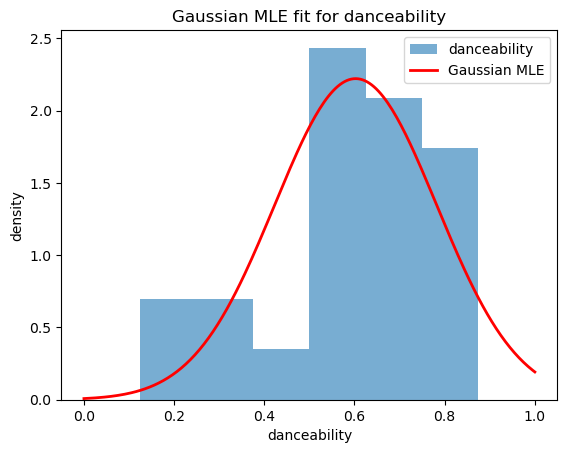

In [7]:
# Pull out danceability as a 1D numpy array
x = spotify['danceability'].values.astype(float)
n = len(x)

# Negative log-likelihood for N(mu, sigma^2), drop constant term, and sigma > 0
def gaussian_nll(mu, s, x):
    sigma = np.exp(s)              
    diff = x - mu
    return n * s + 0.5 * np.sum(diff**2) / (sigma**2)

# Gradient of the negative log-likelihood  w.r.t. mu and s = log(sigma)
def dfd(mu, s, x):
    sigma = np.exp(s)
    diff = x - mu
    dmu = np.sum(mu - x) / (sigma**2)
    ds  = n - np.sum(diff**2) / (sigma**2)
    return dmu, ds

# Gradient descent on the nll
mu = 0.0

# start with sigma = 1
s  = np.log(1.0)     
lr_mu = 1e-3
lr_s  = 1e-3
steps = 50000

loss_list = []

for t in range(steps):
    dmu, ds = dfd(mu, s, x)
    mu = mu - lr_mu * dmu
    s  = s  - lr_s  * ds
    loss_list.append(gaussian_nll(mu, s, x))

sigma = np.exp(s)

print('mu_hat    =', mu)
print('sigma_hat =', sigma)

# pdf for the Gaussian
def gaussian_pdf(z, mu, sigma):
    return (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(z - mu)**2 / (2*sigma**2))

# Grid for plotting the curve
x_grid = np.linspace(0, 1, 200)

# Histogram and fitted Gaussian
plt.hist(x, bins=8, range=(0, 1), density=True, alpha=0.6, label='danceability')
plt.plot(x_grid, gaussian_pdf(x_grid, mu, sigma), 'r-', lw=2, label='Gaussian MLE')
plt.xlabel('danceability')
plt.ylabel('density')
plt.title('Gaussian MLE fit for danceability')
plt.legend()
plt.show()


Part (b)

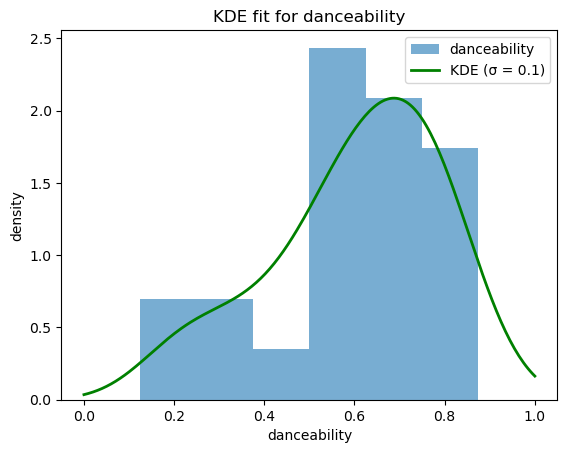

In [8]:
sigma_kde = 0.1

# Gaussian KDE with bandwidth sigma
def kde_gaussian(x_grid, data, sigma):
    n = len(data)
    dens = []

    for z in x_grid:
        diff = (z - data) / sigma
        kernels = np.exp(-0.5 * diff**2)
        val = np.sum(kernels) / (n * sigma * np.sqrt(2*np.pi))
        dens.append(val)

    return np.array(dens)

# Evaluate KDE 
kde_vals = kde_gaussian(x_grid, x, sigma_kde)

# Histogram and KDE curve
plt.hist(x, bins=8, range=(0, 1), density=True, alpha=0.6, label='danceability')
plt.plot(x_grid, kde_vals, 'g-', lw=2, label='KDE (σ = 0.1)')
plt.xlabel('danceability')
plt.ylabel('density')
plt.title('KDE fit for danceability')
plt.legend()
plt.show()


Part (c)

In [9]:
# densities
gauss_vals = gaussian_pdf(x_grid, mu, sigma)
kde_vals   = kde_gaussian(x_grid, x, sigma_kde)

# normalize on [0,1] so each is a proper density
gauss_vals = gauss_vals / np.trapz(gauss_vals, x_grid)
kde_vals   = kde_vals   / np.trapz(kde_vals, x_grid)

# small epsilon to avoid log(0)
eps = 1e-12
p = gauss_vals + eps
q = kde_vals   + eps

# KL divergences with log base 2, NumPy automatic integration using trapz, 
# i did some research and found this to be a slightly nicer numerical integral than a plain Riemann sum, althought the Riemann sum would have been fine as well
# KL(Gaussian || KDE)
KL_G_to_K = np.trapz(p * np.log2(p / q), x_grid)   
# KL(KDE || Gaussian)
KL_K_to_G = np.trapz(q * np.log2(q / p), x_grid)   

print('KL(Gaussian || KDE) =', KL_G_to_K)
print('KL(KDE || Gaussian) =', KL_K_to_G)


KL(Gaussian || KDE) = 0.07045409190025045
KL(KDE || Gaussian) = 0.08278632354301756


/var/folders/vw/c11105x93rdfqx32_1qmzfn40000gn/T/ipykernel_8205/1382694346.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gauss_vals = gauss_vals / np.trapz(gauss_vals, x_grid)
/var/folders/vw/c11105x93rdfqx32_1qmzfn40000gn/T/ipykernel_8205/1382694346.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  kde_vals   = kde_vals   / np.trapz(kde_vals, x_grid)
/var/folders/vw/c11105x93rdfqx32_1qmzfn40000gn/T/ipykernel_8205/1382694346.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  KL_G_to_K = np.trapz(p * np.log2(p / q), x_grid)
/var/folders/vw/c11105x93rdfqx32_1qmzfn40000gn/T/ipykernel_8205/1382694346.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration

I computed KL(Gaussian ‖ KDE) ≈ 0.07 and KL(KDE ‖ Gaussian) ≈ 0.08 (log base 2). The KDE curve follows the histogram more closely than the Gaussian MLE, especially near the peak and at the edges of [0,1]. Based on both the plots and these relatively small but non-zero KL values, I conclude that the KDE with σ = 0.1 fits the danceability data better than the single Gaussian MLE.

### PROBLEM 4: CLASSIFICATION (32 points)

Part (a)

In [10]:
# Read the dataset
spotify = pd.read_csv("ds4400_spotify.csv")
display(spotify.head())

# Save song and artist names, then drop from main df
if {'song_title', 'artist_name'}.issubset(spotify.columns):
    song_info = spotify[['song_title', 'artist_name']]
else:
    song_info = None

spotify = spotify.drop(columns=['song_title', 'artist_name'], errors='ignore')

# Mode (1 = Minor, 0 = Major)
y = (spotify['mode'] == 'Minor').astype(int)

# Drop mode so we only use the other six features
X = spotify.drop(columns=['mode'])

# One-hot encode any remaining categorical features (if any)
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Detect dummy columns (0/1) so we don't rescale them
dummy_mask = X.apply(lambda s: set(s.dropna().unique()) <= {0, 1})
dummy_cols = X.columns[dummy_mask]
X[dummy_cols] = X[dummy_cols].astype('int8')

# Min–max scaling for continuous numeric columns
cont_cols = X.columns.difference(dummy_cols)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X.copy()
X_scaled[cont_cols] = scaler.fit_transform(X_scaled[cont_cols])

# Build final feature matrix with intercept
Phi = X_scaled.copy()
Phi.insert(0, 'intercept', 1.0)

display(Phi.head())
display(y.head())


,song_title,artist_name,danceability,energy,loudness,acousticness,tempo,mode
0,Hawk Em,Pop Smoke,0.680,0.607,-5.523,0.2640,141.992,Major
1,Faith,The Weeknd,0.370,0.603,-7.268,0.6120,175.962,Minor
2,Greek Tragedy - Oliver Nelson TikTok Remix,The Wombats,0.736,0.764,-6.736,0.2220,112.033,Minor
3,Homesick,Noah Kahan,0.505,0.624,-6.526,0.0253,170.076,Major
4,August,flipturn,0.450,0.602,-4.301,0.0892,172.161,Major


,intercept,danceability,energy,loudness,acousticness,tempo
0,1.0,0.731066,0.571661,0.758362,0.323175,0.563378
1,1.0,0.251932,0.565147,0.590638,0.758545,0.836785
2,1.0,0.817620,0.827362,0.641772,0.270630,0.322253
3,1.0,0.460587,0.599349,0.661957,0.024546,0.789411
4,1.0,0.375580,0.563518,0.875817,0.104489,0.806193


0    0
1    1
2    1
3    0
4    0
Name: mode, dtype: int64

Part (b)

In [11]:
import statistics as st

# first column = label (mode), rest = scaled features
mode_df = pd.concat([y.rename('mode'), X_scaled], axis=1)

# k-NN function (L2 norm)
# assumes first column is the label
def knn(data, k='Default'):
    
    if k == 'Default':
        k = round(np.sqrt(data.shape[0]))
    else:
        k = k

    pred_labels = []

    for i in range(data.shape[0]):
        data_t = data.T.copy()
        # remove element i from dataset, get its features (skip label)
        xi = data_t.pop(i).to_numpy()[1:]
        rest = data_t.T.to_numpy()   # dataset now lacks element i

        # distances from xi to all remaining points
        dist_i = []
        for j in range(rest.shape[0]):
            xj = rest[j, 1:]
            dist_i.append(np.linalg.norm(xi - xj))

        # indices of k nearest neighbors
        knns = np.where(np.argsort(dist_i) < k)[0]

        # majority label among neighbors (mode of labels in col 0)
        pred_labels.append(st.mode(rest[knns, 0]))

    true_labels = data.to_numpy()[:, 0].T
    return np.array(pred_labels), true_labels

# run k-NN on the Spotify data
pred_knn, truth_knn = knn(mode_df)

# classification accuracy
acc_knn = np.mean(pred_knn == truth_knn)
print('k-NN training accuracy =', acc_knn)


k-NN training accuracy = 0.391304347826087


Part (c)

In [12]:
# feature matrix (with intercept) and labels
X_log = Phi.values.astype(float)       
y_log = y.values.astype(int)           

# sigmoid 
def sigmoid(x, w):
    return 1 / (1 + np.exp(-x.T.dot(w)))

# gradient of logistic loss by looping
def logistic_grad(X, y, w):
    L = 0
    for i, row in enumerate(X):
        x = row.reshape(X.shape[1], 1)         
        L += (sigmoid(x, w) - y[i]) * x
    dL_dw = L / len(X)
    return dL_dw

# gradient descent routine
def gradient_descent(X, y, w, eta, steps=2000):
    for i in range(steps):
        w = w - eta * logistic_grad(X, y, w)
    return w

# initial weights
w0 = np.zeros((X_log.shape[1], 1))
eta = 0.1

# run GD
w_hat = gradient_descent(X_log, y_log, w0, eta)

# use learned weights to predict all observations
probs_log = []
for row in X_log:
    x = row.reshape(X_log.shape[1], 1)
    probs_log.append(sigmoid(x, w_hat))

probs_log = np.array(probs_log).reshape(-1)
y_pred_log = (probs_log >= 0.5).astype(int)

# classification accuracy
acc_log = np.mean(y_pred_log == y_log)
print('logistic regression training accuracy =', acc_log)




logistic regression training accuracy = 0.7391304347826086


Part (d)

In [13]:
# put logistic weights into a DataFrame
coef_df = pd.DataFrame({
    'feature': Phi.columns,
    'weight': w_hat.reshape(-1)
})
coef_df['abs_weight'] = coef_df['weight'].abs()

# sort by |weight| to see most important predictors
coef_df = coef_df.sort_values('abs_weight', ascending=False)
display(coef_df)


,feature,weight,abs_weight
0,intercept,-2.654757,2.654757
1,danceability,2.117840,2.117840
3,loudness,0.526364,0.526364
2,energy,0.421469,0.421469
5,tempo,0.327676,0.327676
4,acousticness,0.049086,0.049086


For the logistic regression, the largest coefficients in magnitude are for danceability (positive) and then loudness, energy, and tempo (also positive), while acousticness has a very small weight. Because all features were min–max scaled, this means that increasing danceability has the strongest effect on pushing the prediction toward Minor mode (y = 1), followed by modest contributions from louder, more energetic, and faster songs. Acousticness barely moves the log-odds at all, so it has relatively little impact on predicting whether a song is in Major or Minor mode.

Comparing models, the k-NN classifier achieved about 39% training accuracy, while logistic regression achieved about 74%, so logistic regression clearly did a better job predicting the mode. k-NN is very sensitive to the local neighborhood and the small sample size here, so its majority votes can be quite noisy, especially when classes are imbalanced or points cluster oddly in feature space. Logistic regression instead learns a single global decision boundary that uses all the data at once, which tends to generalize better on small datasets and benefits from the min–max scaling, leading to the higher accuracy we observe.